In [2]:
!pip install ultralytics -q

In [4]:
!pip install datasets -q

In [9]:
from ultralytics import YOLO
from datasets import load_dataset
import os
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
from huggingface_hub import login # Import the login function from huggingface_hub

# Authenticate with your Hugging Face token
login() # This will prompt you to enter your token if you haven't already logged in.

# Carregar o dataset
dataset = load_dataset("gabraken/mtg-detection", cache_dir="E:\mtg-card-detector\data_cache")

Resolving data files:   0%|          | 0/45 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/45 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/34 [00:00<?, ?it/s]

In [3]:
# Exibir informações do dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'annotation', 'metadata'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['id', 'image', 'annotation', 'metadata'],
        num_rows: 3000
    })
})


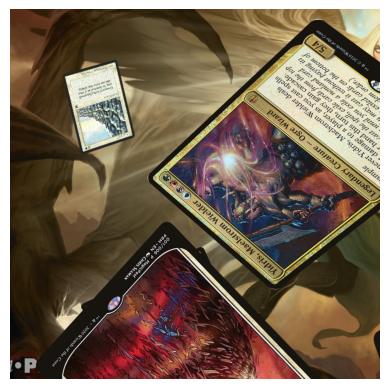

[[1.2141401486057726, 1.4678795924014163, 0.0, -0.17349060781084452, 0.0], [2.126094638022354, 1.3080573306380665, 0.0, -1.955544810963152, 1.0], [1.881311746723621, 0.7035495095398802, 0.0, 2.9247943499869393, 2.0], [1.0128075060895585, 0.894846267436338, 0.0, 1.2329234052958977, 3.0], [0.5128744844531262, 0.6536777500564362, 1.0, 2.6908337028015636, 0.0], [0.20362036721170734, 0.8033541002628757, 1.0, 1.0269245136136984, 1.0], [0.2962033469848015, 0.9564584958958099, 0.0, -0.4437704036117622, 2.0], [0.5887359654229251, 0.817390012011563, 0.0, -2.004723663743774, 3.0], [0.712893015930856, 0.737710908623858, 1.0, -0.6696589493956299, 0.0], [1.2209819970007538, 0.335457264740642, 0.0, -2.5052416725911875, 1.0], [0.8312637525655342, 0.04749939216069357, 1.0, 2.390649441045188, 2.0], [0.39182423791974497, 0.45765457413592836, 1.0, 0.7172775927805438, 3.0], [0.32993400552066, 0.34060526603537145, 1.0, -1.8054134124721006, 0.0], [0.28287502505085343, 0.14372131621371498, 1.0, 2.861263343698

In [12]:
# Selecionar uma amostra do dataset
sample = dataset['train'][0]

# Carregar a imagem
image = cv2.imdecode(np.frombuffer(sample['image'], np.uint8), cv2.IMREAD_COLOR)

# Exibir a imagem usando matplotlib
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Exibir anotações
print(sample['annotation'])
print(sample['metadata'])


In [15]:
#Normalização e tratamento dos dados de treino para o YOLO OBB
import os
import cv2
import numpy as np
import json

# Criação de diretórios
os.makedirs('datasets/data/images/train', exist_ok=True)
os.makedirs('datasets/data/labels/train', exist_ok=True)

# Mapeamento de cor para ID de classe
color_to_class = {
    "W": 0,  # Branco (White)
    "U": 1,  # Azul (Blue)
    "B": 2,  # Preto (Black)
    "R": 3,  # Vermelho (Red)
    "G": 4,  # Verde (Green)
    "C": 5,  # Incolor
    "M": 6   # Multicor
}

# Agrupa os pontos de cada carta com base no corner_id == 0
def group_cards(annotation):
    cards = []
    i = 0
    while i < len(annotation):
        if int(annotation[i][4]) == 0:  # início de nova carta
            card = [annotation[i]]
            for j in range(1, 4):
                if i + j < len(annotation) and int(annotation[i + j][4]) == j:
                    card.append(annotation[i + j])
            if len(card) == 4:
                cards.append(card)
            i += 4
        else:
            i += 1
    return cards

# Converte uma imagem + anotação para arquivos de treino YOLO OBB (normalizado)
def convert_annotation(sample, idx):
    image = cv2.imdecode(np.frombuffer(sample['image'], np.uint8), cv2.IMREAD_COLOR)
    image_path = f'datasets/data/images/train/{idx}.jpg'
    label_path = f'datasets/data/labels/train/{idx}.txt'
    h, w = image.shape[:2]
    cv2.imwrite(image_path, image)

    cards = group_cards(sample['annotation'])

    with open(label_path, 'w') as f:
        for card in cards:
            if len(card) != 4:
                continue

            # Pegamos os 4 pontos normalizados (x, y entre 0 e 1)
            points = [(max(min(p[0], 1.0), 0.0), max(min(p[1], 1.0), 0.0)) for p in card]
            coords = [f"{x:.6f} {y:.6f}" for x, y in points]

            # Identifica a cor da carta a partir dos metadados
            metadata = json.loads(sample['metadata'])
            if not metadata:
                continue
            color_ids = metadata[cards.index(card)]['colors']

            if not color_ids:
                class_id = color_to_class["C"]  # Incolor
            elif len(color_ids) > 1:
                class_id = color_to_class["M"]  # Multicor
            else:
                class_id = color_to_class.get(color_ids[0], color_to_class["C"])  # Cor única ou fallback

            f.write(f"{class_id} " + " ".join(coords) + "\n")

# Aplicar ao conjunto de treino
for idx, sample in enumerate(dataset['train']):
    convert_annotation(sample, idx)
    print(f"Convertido: {idx}")


Convertido: 0
Convertido: 1
Convertido: 2
Convertido: 3
Convertido: 4
Convertido: 5
Convertido: 3
Convertido: 4
Convertido: 5
Convertido: 6
Convertido: 7
Convertido: 8
Convertido: 6
Convertido: 7
Convertido: 8
Convertido: 9
Convertido: 10
Convertido: 11
Convertido: 12
Convertido: 9
Convertido: 10
Convertido: 11
Convertido: 12
Convertido: 13
Convertido: 14
Convertido: 15
Convertido: 16
Convertido: 13
Convertido: 14
Convertido: 15
Convertido: 16
Convertido: 17
Convertido: 18
Convertido: 19
Convertido: 20
Convertido: 17
Convertido: 18
Convertido: 19
Convertido: 20
Convertido: 21
Convertido: 22
Convertido: 23
Convertido: 24
Convertido: 21
Convertido: 22
Convertido: 23
Convertido: 24
Convertido: 25
Convertido: 26
Convertido: 27
Convertido: 25
Convertido: 26
Convertido: 27
Convertido: 28
Convertido: 29
Convertido: 30
Convertido: 28
Convertido: 29
Convertido: 30
Convertido: 31
Convertido: 32
Convertido: 33
Convertido: 34
Convertido: 31
Convertido: 32
Convertido: 33
Convertido: 34
Convertido: 

In [16]:
#Normalização e tratamento dos dados de TESTE para o YOLO OBB
import os
import cv2
import numpy as np
import json

# Criação de diretórios
os.makedirs('datasets/data/images/test', exist_ok=True)
os.makedirs('datasets/data/labels/test', exist_ok=True)

# Mapeamento de cor para ID de classe
color_to_class = {
    "W": 0,  # Branco (White)
    "U": 1,  # Azul (Blue)
    "B": 2,  # Preto (Black)
    "R": 3,  # Vermelho (Red)
    "G": 4,  # Verde (Green)
    "C": 5,  # Incolor
    "M": 6   # Multicor
}

# Agrupa os pontos de cada carta com base no corner_id == 0
def group_cards(annotation):
    cards = []
    i = 0
    while i < len(annotation):
        if int(annotation[i][4]) == 0:  # início de nova carta
            card = [annotation[i]]
            for j in range(1, 4):
                if i + j < len(annotation) and int(annotation[i + j][4]) == j:
                    card.append(annotation[i + j])
            if len(card) == 4:
                cards.append(card)
            i += 4
        else:
            i += 1
    return cards

# Converte uma imagem + anotação para arquivos de treino YOLO OBB (normalizado)
def convert_annotation(sample, idx):
    image = cv2.imdecode(np.frombuffer(sample['image'], np.uint8), cv2.IMREAD_COLOR)
    image_path = f'datasets/data/images/test/{idx}.jpg'
    label_path = f'datasets/data/labels/test/{idx}.txt'
    h, w = image.shape[:2]
    cv2.imwrite(image_path, image)

    cards = group_cards(sample['annotation'])

    with open(label_path, 'w') as f:
        for card in cards:
            if len(card) != 4:
                continue

            # Pegamos os 4 pontos normalizados (x, y entre 0 e 1)
            points = [(max(min(p[0], 1.0), 0.0), max(min(p[1], 1.0), 0.0)) for p in card]
            coords = [f"{x:.6f} {y:.6f}" for x, y in points]

            # Identifica a cor da carta a partir dos metadados
            metadata = json.loads(sample['metadata'])
            if not metadata:
                continue
            color_ids = metadata[cards.index(card)]['colors']

            if not color_ids:
                class_id = color_to_class["C"]  # Incolor
            elif len(color_ids) > 1:
                class_id = color_to_class["M"]  # Multicor
            else:
                class_id = color_to_class.get(color_ids[0], color_to_class["C"])  # Cor única ou fallback

            f.write(f"{class_id} " + " ".join(coords) + "\n")

# Aplicar ao conjunto de treino
for idx, sample in enumerate(dataset['test']):
    convert_annotation(sample, idx)
    print(f"Convertido: {idx}")


Convertido: 0
Convertido: 1
Convertido: 1
Convertido: 2
Convertido: 2
Convertido: 3
Convertido: 3
Convertido: 4
Convertido: 4
Convertido: 5
Convertido: 6
Convertido: 7
Convertido: 8
Convertido: 9
Convertido: 10
Convertido: 5
Convertido: 6
Convertido: 7
Convertido: 8
Convertido: 9
Convertido: 10
Convertido: 11
Convertido: 11
Convertido: 12
Convertido: 13
Convertido: 12
Convertido: 13
Convertido: 14
Convertido: 15
Convertido: 16
Convertido: 14
Convertido: 15
Convertido: 16
Convertido: 17
Convertido: 18
Convertido: 17
Convertido: 18
Convertido: 19
Convertido: 19
Convertido: 20
Convertido: 21
Convertido: 22
Convertido: 23
Convertido: 20
Convertido: 21
Convertido: 22
Convertido: 23
Convertido: 24
Convertido: 25
Convertido: 26
Convertido: 27
Convertido: 24
Convertido: 25
Convertido: 26
Convertido: 27
Convertido: 28
Convertido: 29
Convertido: 28
Convertido: 29
Convertido: 30
Convertido: 31
Convertido: 30
Convertido: 31
Convertido: 32
Convertido: 33
Convertido: 32
Convertido: 33
Convertido: 34

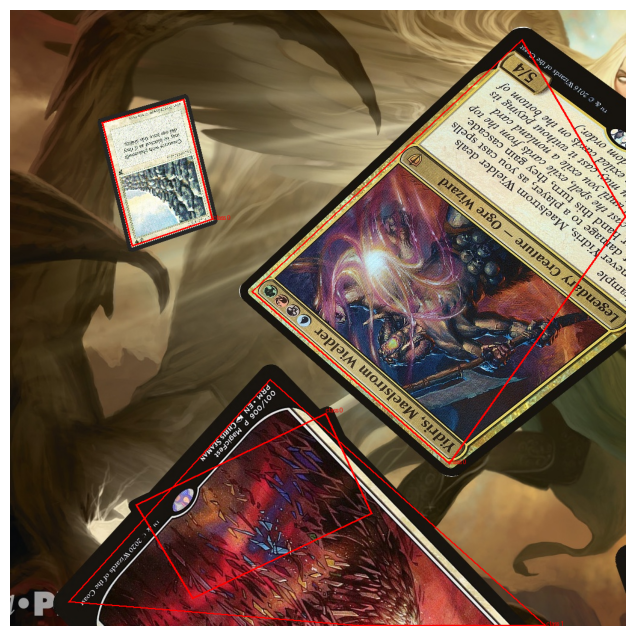

In [ ]:
#Desenha a imagem e o overlay a partir do dataset puro
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Caminhos da imagem e do label
img_path = "datasets/data/images/train/0.jpg"
label_path = "datasets/data/labels/train/0.txt"

# Abrir imagem
img = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(img)
w, h = img.size

# Ler labels e desenhar as quinas como polígono
with open(label_path, "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) != 9:
            print(f"Ignorando linha inválida: {line.strip()}")
            continue

        try:
            coords = list(map(float, parts[1:9]))
            class_id = int(float(parts[8]))
        except ValueError:
            print(f"Erro ao converter linha: {line.strip()}")
            continue

        # Convertendo coordenadas normalizadas para pixels
        points = [(coords[i] * w, coords[i+1] * h) for i in range(0, 8, 2)]
        draw.polygon(points, outline="red", width=3)
        draw.text((points[0][0], points[0][1] - 10), f"class {class_id}", fill="red")

# Mostrar imagem
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()


In [28]:
yaml_content = """
train: data/images/train
val: data/images/test

nc: 7  # n�mero de classes
names: ["Branco (White)", "Azul (Blue)", "Preto (Black)", "Vermelho (Red)", "Verde (Green)", "Incolor", "Multicor"]  # nome da(s) classe(s)

# Para YOLO com caixas rotacionadas (OBB)
obb: true

"""

with open("mtg.yaml", "w") as f:
    f.write(yaml_content)

UnicodeEncodeError: 'charmap' codec can't encode character '\ufffd' in position 63: character maps to <undefined>

In [17]:
from collections import Counter
import os

labels_dir = "datasets/data/labels/train"
class_counts = Counter()

for file in os.listdir(labels_dir):
    with open(os.path.join(labels_dir, file), "r") as f:
        for line in f:
            class_id = line.strip().split()[0]
            class_counts[int(class_id)] += 1

print("Distribuição de classes no conjunto de treino:")
for class_id, count in sorted(class_counts.items()):
    print(f"Classe {class_id}: {count} amostras")


Distribuição de classes no conjunto de treino:
Classe 0: 3746 amostras
Classe 1: 3752 amostras
Classe 2: 4154 amostras
Classe 3: 4226 amostras
Classe 4: 4170 amostras
Classe 5: 7801 amostras
Classe 6: 4801 amostras


In [1]:
!head datasets/data/labels/train/3367.txt

0 1.000000 1.000000 0.554758 1.000000 0.965663 1.000000 1.000000 1.000000
0 0.100405 0.121821 0.035283 0.104208 0.024190 0.146819 0.088391 0.164976
0 0.626030 0.713360 0.966120 0.913518 1.000000 0.683224 0.777045 0.479922


In [10]:
!rm -rf /content/datasets/data

In [1]:
#Checking the GPU and PyTorch version
import torch
print(torch.__version__)           # Should show ≥2.0.0
print(torch.cuda.is_available())   # Must return True
print(torch.cuda.get_device_name(0))  # Should show "GeForce GTX 1650 SUPER"



2.6.0+cu118
True
NVIDIA GeForce GTX 1650 SUPER


In [6]:
#Treinar modelo
from ultralytics import YOLO

data_yaml = 'mtg.yaml'

model = YOLO('yolo11s-obb.pt')  # você pode trocar por 'yolov8s-obb.pt', 'yolov8m-obb.pt', etc.
model.train(
    data=data_yaml,
    epochs=35,
    imgsz=640,
    batch=-1,
    name='train_1650_yolo11s',
    device='0')

New https://pypi.org/project/ultralytics/8.3.103 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.102  Python-3.10.2 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650 SUPER, 4096MiB)
engine\trainer: task=obb, mode=train, model=yolo11s-obb.pt, data=mtg.yaml, epochs=10, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train_1650_yolo11s, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, 

train: Scanning E:\mtg-card-detector\datasets\data\labels\train.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]

train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1032.jpg: 1 duplicate labels removed
train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1056.jpg: 1 duplicate labels removed
train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1081.jpg: 1 duplicate labels removed
train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1086.jpg: 1 duplicate labels removed
train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1122.jpg: 1 duplicate labels removed
train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1176.jpg: 1 duplicate labels removed
train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1186.jpg: 1 duplicate labels removed
train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1214.jpg: 1 duplicate labels removed
train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1220.jpg: 2 duplicate labels removed
train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1514.jpg: 1 duplicate label

AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce GTX 1650 SUPER) 4.00G total, 1.38G reserved, 0.29G allocated, 2.33G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     9716680       22.55         1.309           115           nan        (1, 3, 640, 640)                    list
     9716680       45.09         2.810            51           nan        (2, 3, 640, 640)                    list
     9716680       90.19         5.094            76           nan        (4, 3, 640, 640)                    list
     9716680       180.4         9.567          7534           nan        (8, 3, 640, 640)                    list
     9716680       360.7        18.184     1.924e+04           nan       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 1 for CUDA:0 2.98G/4.00G (75%) 


train: Scanning E:\mtg-card-detector\datasets\data\labels\train.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]

train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1032.jpg: 1 duplicate labels removed
train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1056.jpg: 1 duplicate labels removed
train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1081.jpg: 1 duplicate labels removed
train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1086.jpg: 1 duplicate labels removed
train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1122.jpg: 1 duplicate labels removed
train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1176.jpg: 1 duplicate labels removed
train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1186.jpg: 1 duplicate labels removed
train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1214.jpg: 1 duplicate labels removed
train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1220.jpg: 2 duplicate labels removed
train: WARNING  E:\mtg-card-detector\datasets\data\images\train\1514.jpg: 1 duplicate label


val: Scanning E:\mtg-card-detector\datasets\data\labels\test.cache... 3000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3000/3000 [00:00<?, ?it/s]

val: WARNING  E:\mtg-card-detector\datasets\data\images\test\0.jpg: 3 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1.jpg: 2 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1016.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1018.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1026.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1035.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1055.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\108.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1113.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1127.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-d

Plotting labels to runs\obb\train_1650_yolo11s\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\obb\train_1650_yolo11s
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.725G     0.8908       2.38      1.725          2        640: 100%|██████████| 10000/10000 [20:17<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3000/3000 [02:32<00:00, 19.69it/s]


                   all       3000       9606      0.158      0.447      0.139       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10       1.1G     0.7623      1.702      1.626          2        640: 100%|██████████| 10000/10000 [19:49<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3000/3000 [02:30<00:00, 19.97it/s]

                   all       3000       9606      0.221      0.447      0.216      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10       1.1G      0.735      1.574        1.6          2        640: 100%|██████████| 10000/10000 [19:42<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3000/3000 [02:33<00:00, 19.54it/s]


                   all       3000       9606      0.236      0.421      0.231       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.14G     0.6984      1.493      1.574          1        640: 100%|██████████| 10000/10000 [19:42<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3000/3000 [02:35<00:00, 19.31it/s]


                   all       3000       9606      0.281      0.428       0.26      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.14G     0.6521      1.377      1.529          2        640: 100%|██████████| 10000/10000 [19:43<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3000/3000 [02:31<00:00, 19.77it/s]


                   all       3000       9606      0.385      0.441      0.325      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.14G     0.6206      1.275       1.52          6        640: 100%|██████████| 10000/10000 [19:41<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3000/3000 [02:30<00:00, 19.91it/s]


                   all       3000       9606      0.413      0.426       0.35        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.14G     0.5812      1.178      1.475          1        640: 100%|██████████| 10000/10000 [19:40<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3000/3000 [02:32<00:00, 19.64it/s]


                   all       3000       9606      0.499      0.443      0.411      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.14G     0.5554      1.106      1.453          3        640: 100%|██████████| 10000/10000 [19:43<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3000/3000 [02:29<00:00, 20.03it/s]

                   all       3000       9606       0.59      0.457       0.46      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.14G     0.5271      1.016      1.437          2        640: 100%|██████████| 10000/10000 [19:38<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3000/3000 [02:32<00:00, 19.72it/s]


                   all       3000       9606      0.626      0.462      0.474      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.14G     0.5114     0.9435      1.413          1        640: 100%|██████████| 10000/10000 [19:44<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3000/3000 [02:31<00:00, 19.83it/s]

                   all       3000       9606      0.634      0.455      0.471      0.408



10 epochs completed in 3.734 hours.
Optimizer stripped from runs\obb\train_1650_yolo11s\weights\last.pt, 19.8MB
Optimizer stripped from runs\obb\train_1650_yolo11s\weights\best.pt, 19.8MB

Validating runs\obb\train_1650_yolo11s\weights\best.pt...
Ultralytics 8.3.102  Python-3.10.2 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650 SUPER, 4096MiB)
YOLO11s-obb summary (fused): 109 layers, 9,701,496 parameters, 0 gradients, 22.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3000/3000 [01:26<00:00, 34.61it/s]


                   all       3000       9606      0.627      0.461      0.474      0.411
                     W        942       1123      0.468      0.388      0.328      0.285
                     U        917       1084      0.799      0.511      0.564      0.494
                     B        982       1172      0.529      0.431      0.423      0.378
                     R       1071       1271      0.769      0.549      0.578      0.497
                     G       1026       1270      0.777      0.454      0.505      0.433
                     C       1676       2292      0.576      0.384      0.429      0.365
                     M       1148       1394      0.474       0.51       0.49      0.425
Speed: 1.4ms preprocess, 14.9ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\obb\train_1650_yolo11s


ultralytics.utils.metrics.OBBMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000186A3453370>
curves: []
curves_results: []
fitness: np.float64(0.4173894904362207)
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.28535,     0.49419,     0.37824,     0.49672,     0.43301,     0.36545,     0.42485])
names: {0: 'W', 1: 'U', 2: 'B', 3: 'R', 4: 'G', 5: 'C', 6: 'M'}
plot: True
results_dict: {'metrics/precision(B)': np.float64(0.6274427821383546), 'metrics/recall(B)': np.float64(0.4609170885269615), 'metrics/mAP50(B)': np.float64(0.47385253853729387), 'metrics/mAP50-95(B)': np.float64(0.41111581842499034), 'fitness': np.float64(0.4173894904362207)}
save_dir: WindowsPath('runs/obb/train_1650_yolo11s')
speed: {'preprocess': 1.4244951333918532, 'inference': 14.931525966676418, 'loss': 

In [7]:
#Testar modelo
from ultralytics import YOLO

# Carregue o modelo treinado
model = YOLO("runs/obb/train_1650_yolo11s/weights/best.pt")

# Avaliar o modelo no conjunto de validação
metrics = model.val(data="mtg.yaml", imgsz=640, iou=0.5)

# Exibir métricas principais
print("\n--- Métricas da Validação ---")
print(f"Precision:  {metrics.box.mp:.4f}")
print(f"Recall:     {metrics.box.mr:.4f}")
print(f"mAP@0.5:    {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")
print(f"Classes:    {metrics.box.nc}")


Ultralytics 8.3.102  Python-3.10.2 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650 SUPER, 4096MiB)
YOLO11s-obb summary (fused): 109 layers, 9,701,496 parameters, 0 gradients, 22.3 GFLOPs


val: Scanning E:\mtg-card-detector\datasets\data\labels\test.cache... 3000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3000/3000 [00:00<?, ?it/s]

val: WARNING  E:\mtg-card-detector\datasets\data\images\test\0.jpg: 3 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1.jpg: 2 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1016.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1018.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1026.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1035.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1055.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\108.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1113.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1127.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-d


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:17<00:00,  2.44it/s]


                   all       3000       9606      0.626      0.465      0.477      0.413
                     W        942       1123      0.458      0.399      0.329      0.286
                     U        917       1084      0.815      0.512      0.568      0.496
                     B        982       1172      0.519      0.439      0.425      0.379
                     R       1071       1271      0.778       0.55      0.582      0.498
                     G       1026       1270      0.779      0.451      0.506      0.433
                     C       1676       2292      0.561      0.393      0.433      0.367
                     M       1148       1394      0.474      0.513      0.495      0.428
Speed: 1.1ms preprocess, 12.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\obb\val14

--- Métricas da Validação ---
Precision:  0.6262
Recall:     0.4653
mAP@0.5:    0.4769
mAP@0.5:0.95: 0.4126
Classes:    7


In [ ]:
# TESTE - Usar Modelo
from ultralytics import YOLO
import cv2
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np

# Mapeamento de classes
COLOR_MAP = {
    0: ("Branco", (255, 255, 255)),
    1: ("Azul", (255, 0, 0)),
    2: ("Preto", (128, 0, 150)),
    3: ("Vermelho", (0, 0, 255)),
    4: ("Verde", (0, 255, 0)),
    5: ("Incolor", (100, 100, 100)),
    6: ("Multicor", (0, 255, 255))
}

# Carrega o modelo
model = YOLO("runs/obb/train_1650_yolo11s_10epochs/weights/best.pt")

# Faz a predição
results = model("IMG_8231.HEIC", conf=0.6)
r = results[0]
img = r.orig_img.copy()
obbs = r.obb
num_cartas = len(obbs)

print(f"\n🔍 {num_cartas} cartas encontradas")

# Process each detection
for i, obb in enumerate(obbs):
    conf = float(obb.conf[0])
    xyxyxyxy = obb.xyxyxyxy[0].cpu().numpy().reshape(-1, 2)
    class_id = int(obb.cls[0])
    
    # Get the full class name and box color
    class_name, box_color = COLOR_MAP.get(class_id, ("?", (1, 1, 1)))
    
    pts = np.int32(xyxyxyxy).reshape((-1, 1, 2))
    cv2.polylines(img, [pts], isClosed=True, color=box_color, thickness=20)
    
    # Text with full class name and confidence
    x, y = int(pts[0][0][0]), int(pts[0][0][1])
    text = f'{class_name} ({conf:.2f})'
    
    # Add a black background rectangle for the text
    text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 2, 2)[0]
    text_x, text_y = x, y - 10
    cv2.rectangle(img, (text_x, text_y - text_size[1] - 5), (text_x + text_size[0] + 5, text_y + 5), (0, 0, 0), -1)
    cv2.putText(img, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 2, box_color, 5)
    
    print(f" - Carta {i+1}: Classe = {class_name}, Confiança = {conf:.2f}")

# Exibe imagem
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"{num_cartas} cartas encontradas")
plt.show()



image 1/1 e:\mtg-card-detector\IMG_8231.HEIC: 640x480 13.8ms
Speed: 3.5ms preprocess, 13.8ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 480)

🔍 7 cartas encontradas
 - Carta 1: Classe = Multicor, Confiança = 0.84
 - Carta 2: Classe = Verde, Confiança = 0.82
 - Carta 3: Classe = Multicor, Confiança = 0.80
 - Carta 4: Classe = Preto, Confiança = 0.74
 - Carta 5: Classe = Branco, Confiança = 0.66
 - Carta 6: Classe = Preto, Confiança = 0.62
 - Carta 7: Classe = Multicor, Confiança = 0.60


In [ ]:
#Mostrar lista de classes aprendidas
from ultralytics import YOLO

# Carregue o modelo
model = YOLO("runs/obb/train_1650_yolo11s/weights/best.pt")

# Print das classes aprendidas
print("📚 Classes aprendidas pelo modelo:")
for i, name in enumerate(model.names):
    print(f"{i}: {name}")

📚 Classes aprendidas pelo modelo:
0: 0
1: 1
2: 2
3: 3
4: 4
5: 5
6: 6


In [13]:
#Precision por classe
from ultralytics import YOLO

# Carrega o modelo treinado
model = YOLO("runs/obb/train_1650_yolo11s/weights/best.pt")

# Pega os nomes das classes
names = model.names

# Imprime métricas por classe
print("\n📊 Desempenho por classe:")
for i, name in names.items():
    precision, recall, map50, map50_95 = metrics.class_result(i)
    print(f"Classe {i} ({name}):")
    print(f"  - Precision:      {precision:.2f}")
    print(f"  - Recall:         {recall:.2f}")
    print(f"  - mAP@0.5:        {map50:.2f}")
    print(f"  - mAP@0.5:0.95:   {map50_95:.2f}")



📊 Desempenho por classe:
Classe 0 (W):
  - Precision:      0.46
  - Recall:         0.40
  - mAP@0.5:        0.33
  - mAP@0.5:0.95:   0.29
Classe 1 (U):
  - Precision:      0.81
  - Recall:         0.51
  - mAP@0.5:        0.57
  - mAP@0.5:0.95:   0.50
Classe 2 (B):
  - Precision:      0.52
  - Recall:         0.44
  - mAP@0.5:        0.42
  - mAP@0.5:0.95:   0.38
Classe 3 (R):
  - Precision:      0.78
  - Recall:         0.55
  - mAP@0.5:        0.58
  - mAP@0.5:0.95:   0.50
Classe 4 (G):
  - Precision:      0.78
  - Recall:         0.45
  - mAP@0.5:        0.51
  - mAP@0.5:0.95:   0.43
Classe 5 (C):
  - Precision:      0.56
  - Recall:         0.39
  - mAP@0.5:        0.43
  - mAP@0.5:0.95:   0.37
Classe 6 (M):
  - Precision:      0.47
  - Recall:         0.51
  - mAP@0.5:        0.50
  - mAP@0.5:0.95:   0.43
